In [1]:
%matplotlib inline
import re
import importlib
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from spiker import *
#from IPython.display import clear_output, Image, display, HTML

In [2]:
# Generate simulation data
def gen_data(nblocks,f1,f2,tseries,amp=1e-9):
    """
    Generates a time series comprising nblocks of data
    Each block is some combination of two sinusoids.
    nblocks = number of blocks
    tseries = Tseries object. Tseries is a datastructure 
        that makes it easy to deal with time-series data
    amp = Scales the entire data block
    """
    time = tseries.time
    Ts = tseries.Ts
    ip = np.array([])
    op = np.array([])
    tblockend = int(len(time)/nblocks)
    timeblock = time[:tblockend]
    for index in range(nblocks):
        if np.random.randint(2):
            block = 2*np.sin(2*np.pi*timeblock*f2)+np.sin(2*np.pi*timeblock*f1)+2
            ip = np.concatenate((ip,block))
            op = np.concatenate((op,np.zeros_like(timeblock)))
        else:
            block = 0.3*np.sin(2*np.pi*timeblock*f2)+np.sin(2*np.pi*timeblock*f2)**2+1
            ip = np.concatenate((ip,block))
            op = np.concatenate((op,np.ones_like(timeblock)))
    return amp*ip, amp*op

In [3]:
# Transient simulation parameters for the spiking simulation
Ts = 1e-6 # step time
tstart = 0 # Simulation start time in seconds
tstop = 0.5 # Simulation stop time in seconds
tseries = gen_time(tstart,tstop,Ts) # obtain the time series input sample
time = tseries.time # the series of time samples

In [4]:
# Neuron constants to setup the neuron model and reserovoir decay
Cmem  = 2e-12 # Membrane cap
Kappa = 0.7
Temp  = 300 # temperature in kelvin
Ut    = 1.38064852e-23 * Temp/1.60217662e-19 # kt/q
Itau  = 50e-12 #50e-12
Ith   = 50e-12 #5e-9
Iin   = 50e-9
gain  = Ith/Itau # DPI gain
tau   = Cmem*Ut/(Kappa * Itau)
print(f'Time constant is {tau} seconds')

Time constant is 0.001477256629974861 seconds


In [5]:
# Test data generation
nblocks = 5
f1 = 15
f2 = 4
amp = 10e-9
test_ip, test_op = gen_data(nblocks,f1,f2,tseries,amp)

ip = Tseries(test_ip,time,Ts)
op = Tseries(test_op,time,Ts)

#test_ip = np.vstack((amp*np.ones_like(tseries.time),test_ip)) # adding bias
test_ip = np.vstack((amp*np.zeros_like(tseries.time),test_ip)) # adding bias

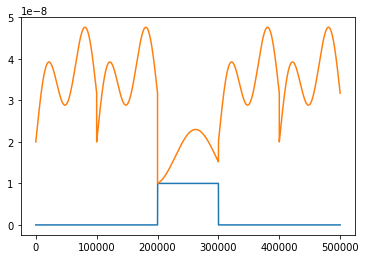

In [6]:
plt.plot(test_op)
plt.plot(test_ip[1,:])

In [7]:
# --------------------------------
# Standard ESN using real elements
# --------------------------------
def realesn(inSize=1, 
            outSize=1, 
            resSize=20):

    """
    inSize = input dimension
    outSize = output dimension
    resSize = size of the reservoir
    """
    
    # Generate input connectivity weights
    Win = (np.random.rand(resSize,1+inSize)-0.5) * 1

    # Recurrent connecivity weights
    W = np.random.rand(resSize,resSize)-0.5
    # compute the spectral radius
    radius = np.max(np.abs(np.linalg.eigvals(W)))
    # rescale to desired spectral radius
    W = W * (1.0 / radius)

    # Output weights
    Wout = np.random.rand(outSize,1+inSize+resSize)-0.5

    # Generate graph for visualization
    G,W_full = create_graph(W,Win,Wout)
    plt.tight_layout()
    # plt.savefig('ESNgraph.pdf')
    
    nnodes,nip,nnip,nnres,nop = compute_nodes(Win,Wout,W)    
    op = np.zeros((outSize,len(tseries.time)))
    x = np.zeros((resSize,1))
    states = np.zeros((resSize,len(tseries.time)))
    res = np.zeros((outSize,1))
    
    # the retention factor inside reservoir = exp(-nsamples_in_tau/a)
    # chosen so that in time 10*tau, the value of exponent is almost 0
    a = 1 - np.exp(-Ts/tau)
    
    for t in range(len(test_ip[0,:])):
        u = test_ip[:,t]
        u.shape = (len(u),1)
        data_in = np.dot( Win, u)
        data_in.shape = (resSize,1)

        x_ip = data_in + np.dot( W, x )
        x_ip = np.maximum(x_ip,0)
        x = (1-a)*x + a*x_ip
        
        res_ip = np.dot(Wout, np.vstack((u,x)))
        res_ip = np.maximum(res_ip,0)
        res = (1-a)*res + a*res_ip

        # Save state transient output
        x.shape = (resSize,)
        states[:,t] = x + 0
        op[:,t] = res[:,0]
        x.shape = (resSize,1)
    return op, states, Win, W, Wout

Total nodes # =  25
Input nodes # =  2
Input neuron # =  2
Reservoir neuron # =  20
Output neuron # =  1


/home/manuvn/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


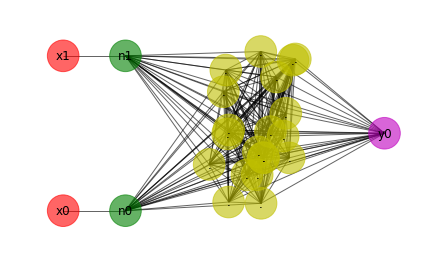

In [8]:
# define reservoir properties
inSize, outSize, resSize = 1, 1, 20

# Let reservoir run
op, res_states, Win, W, Wout = realesn(inSize, outSize, resSize)

In [9]:
# we'll disregard the first few states and solve for Wout
transient = 100
extended_states = np.concatenate((test_ip, res_states),axis=0)
Wout = np.dot(test_op[transient:], 
               np.linalg.pinv(extended_states[:, transient:]))

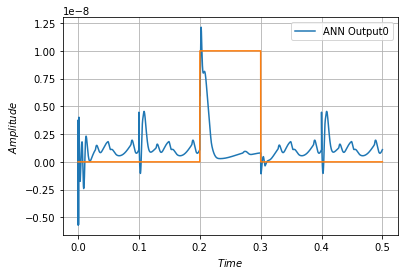

In [10]:
# Compute the output after training
resop = np.dot(Wout, extended_states)
if resop.ndim == 1:
    resop.shape = (1,len(resop))
for index in range(outSize):
    result = Tseries(resop[index,:],tseries.time)
    result.plot(label = "ANN Output"+str(index))
plt.plot(tseries.time, test_op, label = 'Expected output')
#plt.savefig("ANN-ESN.pdf")

In [11]:
# Sigma Delta ESN - numpy
# ---------------------------------
def sdesn(Win, Wout, W):
    """
    Runs transient spiking simulation of an Echo-state 
    network given a set of Win, Wout, and W
    Win = Input connectivity matrix
    Wout = Readout connectivity matrix
    W = Recurrent connectivity matrix
    
    # Variables used in this function:
    # X = input: dim = (nip + 1) x 1
    # N = input neurons to convert X to spikes: dim = nip x 1
    # R = reservoir neurons: dim = nres x nres
    # Y = output neurons: dim = nop x 1
    # Wab = weight matrix such that B = W.A
    # Xip = input to the layer X
    # Xop = output from layer X
    """
    
    nnodes,nip,nnip,nnres,nop = compute_nodes(Win,Wout,W)
    X = test_ip
    N = Neuron(nnip,
             ipItau  = 50e-12,
             ipIth   = 50e-12,
             fbItau  = 10e-12,
             fbIth   = 300e-12,
             fbIin   = 40e-9,
             eItau   = 10e-12,
             eIth    = 50e-9,
             Ts=Ts)
    R = Neuron(nnres,
             ipItau  = 50e-12,
             ipIth   = 50e-12,
             fbItau  = 10e-12,
             fbIth   = 300e-12,
             fbIin   = 40e-9,
             eItau   = 10e-12,
             eIth    = 50e-9,
             Ts=Ts)
    Y = Neuron(nop,
             ipItau  = 50e-12,
             ipIth   = 50e-12,
             fbItau  = 10e-12,
             fbIth   = 300e-12,
             fbIin   = 40e-9,
             eItau   = 10e-12,
             eIth    = 50e-9,
             Ts=Ts)
    O = Vsyn(nop,
             Itau  = 30e-12,
             Ith   = 30e-12,
             Ts=Ts)    # Readout to LPF neuron output

    Wxn = np.eye(nip)
    Wnr = Win
    Wrr = W
    Wry = Wout
    Wyo = np.eye(nop)
    
    Rop = np.zeros(nnres)
    
    count = nop
    esn = np.zeros((count,len(tseries.time)))
    for index in range(len(tseries.time)):
        ip = X[:,index]
    
        Nip = np.dot(Wxn,ip)
        Nop = N.compute(Nip)
        
        Rip = np.dot(Wnr,Nop) + np.dot(Wrr,Rop)
        Rop = R.compute(Rip)
        #print(f'{Wry.shape} and {ip.shape} and {Rop.shape} and {np.hstack((ip,Rop)).shape}')
        Yip = np.dot(Wry,np.hstack((ip,Rop)))
        Yop = Y.compute(Yip)
        
        
        O.compute(Yop)
        esn[:,index] = O.states
    return esn,count

In [12]:
esn,count = sdesn(Win, Wout, W)

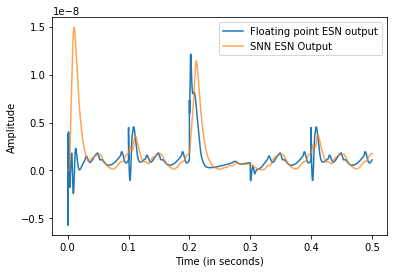

In [15]:
plt.plot(tseries.time, resop[0,:], label = 'Floating point ESN output')
plt.plot(tseries.time, esn[0,:], label = 'SNN ESN Output', alpha=0.7)
plt.ylabel('Amplitude')
plt.xlabel('Time (in seconds)')
plt.legend()
plt.savefig("ANN-SDNN.pdf", dpi=300)

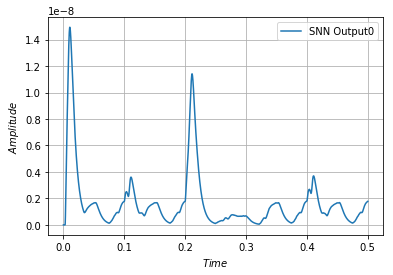

In [14]:
for index in range(count):
    esnres = Tseries(esn[index,:],tseries.time)
    esnres.plot(0, label = "SNN Output"+str(index))
#plt.savefig("SDNN-ESN.pdf")